In [1]:

        
import os
import re
import cv2,time
import string
from pandas import DataFrame, cut, Series, read_csv
import numpy as np
from scipy.stats import gaussian_kde
from scipy import ndimage
import sklearn.neighbors.typedefs
import sklearn.utils._cython_blas
import sklearn.neighbors.quad_tree
import sklearn.tree
import sklearn.tree._utils
from sklearn.cluster import KMeans
from sklearn.neighbors import KDTree
from sklearn.linear_model import LinearRegression
from shapely.geometry import Point
from shapely import geometry
from IPython import display
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')


def AreaOfContour(x):
    return x[2]*x[3]
    
def BoundingBox1(file=None, kernel_size=17, iterations=11, resize=False, contours=[], Save=False, Filter=False, 
                thickness = 1, labels=None, ContourN=None,Orientation=[], Remove_Lines=True, text_size=1):
    if isinstance(file,str):
        im1 = cv2.imread(file, 0)
        im = cv2.imread(file)
    else:
        im = file
        if len(im.shape)>2:
            im1 = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    
    Original1 = im.copy()
    
    if Remove_Lines:
        im = RemoveLines(im)
    
    if resize:
        base = 1200
        im1 = cv2.resize(im1,(base,int(im1.shape[0]/(im1.shape[1]/base))))
        im = cv2.resize(im,(base,int(im.shape[0]/(im.shape[1]/base))))
        Original = cv2.resize(Original1,(base,int(im.shape[0]/(im.shape[1]/base))))
   
    image_area = im1.shape[0]* im1.shape[1]
    count = 0
    if len(contours)==0:
        ret,thresh1 = cv2.threshold(im1,189,255,cv2.THRESH_BINARY_INV)
        kernel = np.ones((kernel_size, kernel_size),np.uint8)
        dilated = cv2.dilate(thresh1,kernel,iterations = iterations)
        contours, hierarchy = cv2.findContours(dilated,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
         
        cordinates = []
        contours1 = []
        # Extracting the Outer Bound boxes
        #contours = [(cnt,hie)[0] for cnt,hie in zip(contours,hierarchy[0]) if hie[2] != -1]
        # Extracting the Boxes with more than 8% area
        for cnt,hie in zip(contours,hierarchy[0]):
            #x,y,w,h = cnt[0],cnt[1],cnt[2],cnt[3]
            x,y,w,h = cv2.boundingRect(cnt)
            #bound the images
            if Filter:
                if hie[-1]==-1:
                    #bound the images
                    cordinates.append((x,y,w,h))
                    cv2.rectangle(im,(x,y),(x+w,y+h),(0,255,0),thickness)
                    #im = cv2.putText(im, str(count), (x,y-5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,255), 1)
                    contours1.append(cnt)
                    letter = Original[y:y+h,x:x+w]
                    if Save:
                        cv2.imwrite('letters/l-{}.jpg'.format(count),letter)
                        count +=1
            else:
                cv2.rectangle(im,(x,y),(x+w,y+h),(0,255,0),thickness)
                cordinates.append((x,y,w,h))
                contours1.append(cnt)
                
        return contours1, cordinates, im, Original1, hierarchy
    else:
        if ContourN!=None:
            labels1 = np.arange(len(contours))
        if labels!=None:
            labels1 = labels.copy()
        if len(Orientation)==0:
            Orientation = list(np.ones(len(contours)))
        for cnt in contours:
            x,y,w,h = cnt[:4]
            if Orientation[count]:
                cv2.rectangle(im,(x,y),(x+w,y+h),(0,255,0),thickness)
            else:               
                cv2.rectangle(im,(x,y),(x+w,y+h),(0,0,255),thickness)
            if labels!=None or ContourN!=None:
                im = cv2.putText(im, str(labels1[count]), (x-5,y-5), cv2.FONT_HERSHEY_SIMPLEX, 
                                 text_size, (0,0,255), 1)
            count+=1
        return  im
    
    
    
def FilterContours(cordinates):
    # Creating the Numpy array of filtered Contour Coordinates
    ContourInfo = np.array(cordinates)
    # Finding the Area of each contour and concatenating the area to axis of numpy array
    ContourAreas = np.apply_along_axis(AreaOfContour,1,ContourInfo)[:,None]
    ContourInfo = np.concatenate([ContourInfo,ContourAreas],axis=1)
    # Sorting the Contours based on the Area of contours
    ContourInfo = ContourInfo[ContourInfo[:,4].argsort()[::-1]]
    # Adding Flag of Table boundary to Contoursa
    ContourInfo = np.concatenate([ContourInfo,np.zeros(len(ContourInfo)).astype(int)[:,None]],axis=1)


    count = 0

    # Filtering the Inner Bounded Contours from Tables by looping the through the Contours sorted by Area,
    # All contours will be checked with the First level area contours if it fits inside, which ever iside of it, will be Deleted from that.
    while (len(ContourInfo) !=  ContourInfo[:,5].sum()):
        # Picking First level of Contour from Area
        ContourInfo[count][-1] = 1
        Cont1 = ContourInfo[count]
        x,y,w,h = Cont1[0],Cont1[1],Cont1[2],Cont1[3]
        polygon = geometry.polygon.Polygon([(x,y),(x,y+h),(x+w,y+h),(x+w,y)])

        InnerContours = []
        # Checking the Each contour one by one till it reaches to Low level and appending the rows of contours inside of it
        for val,Cont2 in enumerate(ContourInfo[count+1:]):
            #Cont2 = ContourInfo[1]
            X,Y,W,H = Cont2[0],Cont2[1],Cont2[2],Cont2[3]
            if any([polygon.contains(Point(point)) for point in [(X,Y),(X,Y+H),(X+W,Y+H),(X+W,Y)]]):
                other_polygon = geometry.polygon.Polygon([(X,Y),(X,Y+H),(X+W,Y+H),(X+W,Y)])
                if polygon.intersection(other_polygon).area/other_polygon.area > 0.45:
                    InnerContours.append(val+count+1)
        # Deleting the Contours which are inside of it.
        ContourInfo = np.delete(ContourInfo,InnerContours, axis=0)
        count +=1
    return ContourInfo    



def RemoveLines(im):
    img=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    img = cv2.bitwise_not(img)
    th2 = cv2.adaptiveThreshold(img,255, cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,15,-2)


    horizontal = th2
    rows,cols = horizontal.shape
    horizontalsize = int(cols / 30)
    horizontalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (horizontalsize,1))
    horizontal = cv2.erode(horizontal, horizontalStructure, (-1, -1))
    horizontal = cv2.dilate(horizontal, horizontalStructure, (-1, -1))


    Vertical = cv2.rotate(th2,cv2.ROTATE_90_CLOCKWISE)
    rows,cols = Vertical.shape
    Verticalsize = int(cols / 30)
    VerticalStructure = cv2.getStructuringElement(cv2.MORPH_RECT, (Verticalsize,1))
    Vertical = cv2.erode(Vertical, VerticalStructure, (-1, -1))
    Vertical = cv2.dilate(Vertical, VerticalStructure, (-1, -1))

    im[horizontal==255] = [255,255,255]
    im = cv2.rotate(im,cv2.ROTATE_90_CLOCKWISE)
    im[Vertical==255] = [255,255,255]
    im = cv2.rotate(im,cv2.ROTATE_90_COUNTERCLOCKWISE)
    return im



def NearestPoints(Labels1,center,H_thr):
    InPoints = []
    for p in Labels1:
        dist = geometry.Point(center).distance(geometry.Point((p[3],p[4])))
        if dist<2*H_thr:
            InPoints.append(p[0])
    return np.array(InPoints).astype(int)

def Layer2_NearestPoints(InPoints, Labels, H_thr, cluster):
    Layer2 = []
    Labels1 = Labels[Labels[:,1]==0]
    for ind in InPoints:
        center = (Labels[ind][3],Labels[ind][4])
        InPoints1  = NearestPoints(Labels1.copy(),center,H_thr)
        Labels1[np.isin(Labels1[:,0],InPoints1),2] = cluster
        Labels1 = Labels1[Labels1[:,2]==0]
        
        Layer2.append(InPoints1)
    return np.unique(np.hstack(Layer2))


def FindNearestClusterPoints(CenterPoints, H_thr):
    C_Points = np.asarray(CenterPoints)
    Labels = np.vstack([np.arange(len(C_Points)), np.zeros(len(C_Points)),np.zeros(len(C_Points))]).T
    Labels = np.hstack([Labels,np.asarray(C_Points)])

    cluster = 1
    ind = 0

    for temp in range(Labels.shape[0]):

        center = (Labels[ind][3],Labels[ind][4])
        Labels[ind,1] = cluster
        Labels1 = Labels[Labels[:,1]==0]
        InPoints = NearestPoints(Labels1.copy(),center,H_thr)
        Labels[np.isin(Labels[:,0],InPoints),[1]] = cluster
        Labels[np.isin(Labels[:,0],InPoints),[2]] = cluster

        if len(InPoints)>0:
            InPoints2 = []
            while len(InPoints) != 0:
                InPoints = Layer2_NearestPoints(InPoints, Labels.copy(), H_thr, cluster)
                Labels[InPoints,1] = cluster
                InPoints2.append(InPoints)

        if Labels[Labels[:,1]==0].shape[0] == 0:
            break
        ind = int(Labels[Labels[:,1]==0][0][0])
        cluster +=1
    return Labels[:,1].astype(int)




C:\Users\viswanadhapa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.typedefs module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
C:\Users\viswanadhapa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.quad_tree module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
import os
import pytesseract
from pdf2image import convert_from_path
path = r'D:\Projects\Projects2\CandidateSourcing\Data Scientist' 
file = os.listdir(path)[3]
pages = convert_from_path(os.path.join(path,file), 500)
for i,page in enumerate(pages):
    page.save(os.path.join(path,'temp',str(i)+'-'+file.split('.')[0]+'.jpeg'))

In [17]:
image = os.listdir('Data Scientist/temp')[0]

In [19]:
%%time 
text = pytesseract.image_to_string(os.path.join('Data Scientist/temp',image))

frame1 = pytesseract.image_to_data(os.path.join('Data Scientist/temp',image))

frame = pytesseract.image_to_boxes(os.path.join('Data Scientist/temp',image))

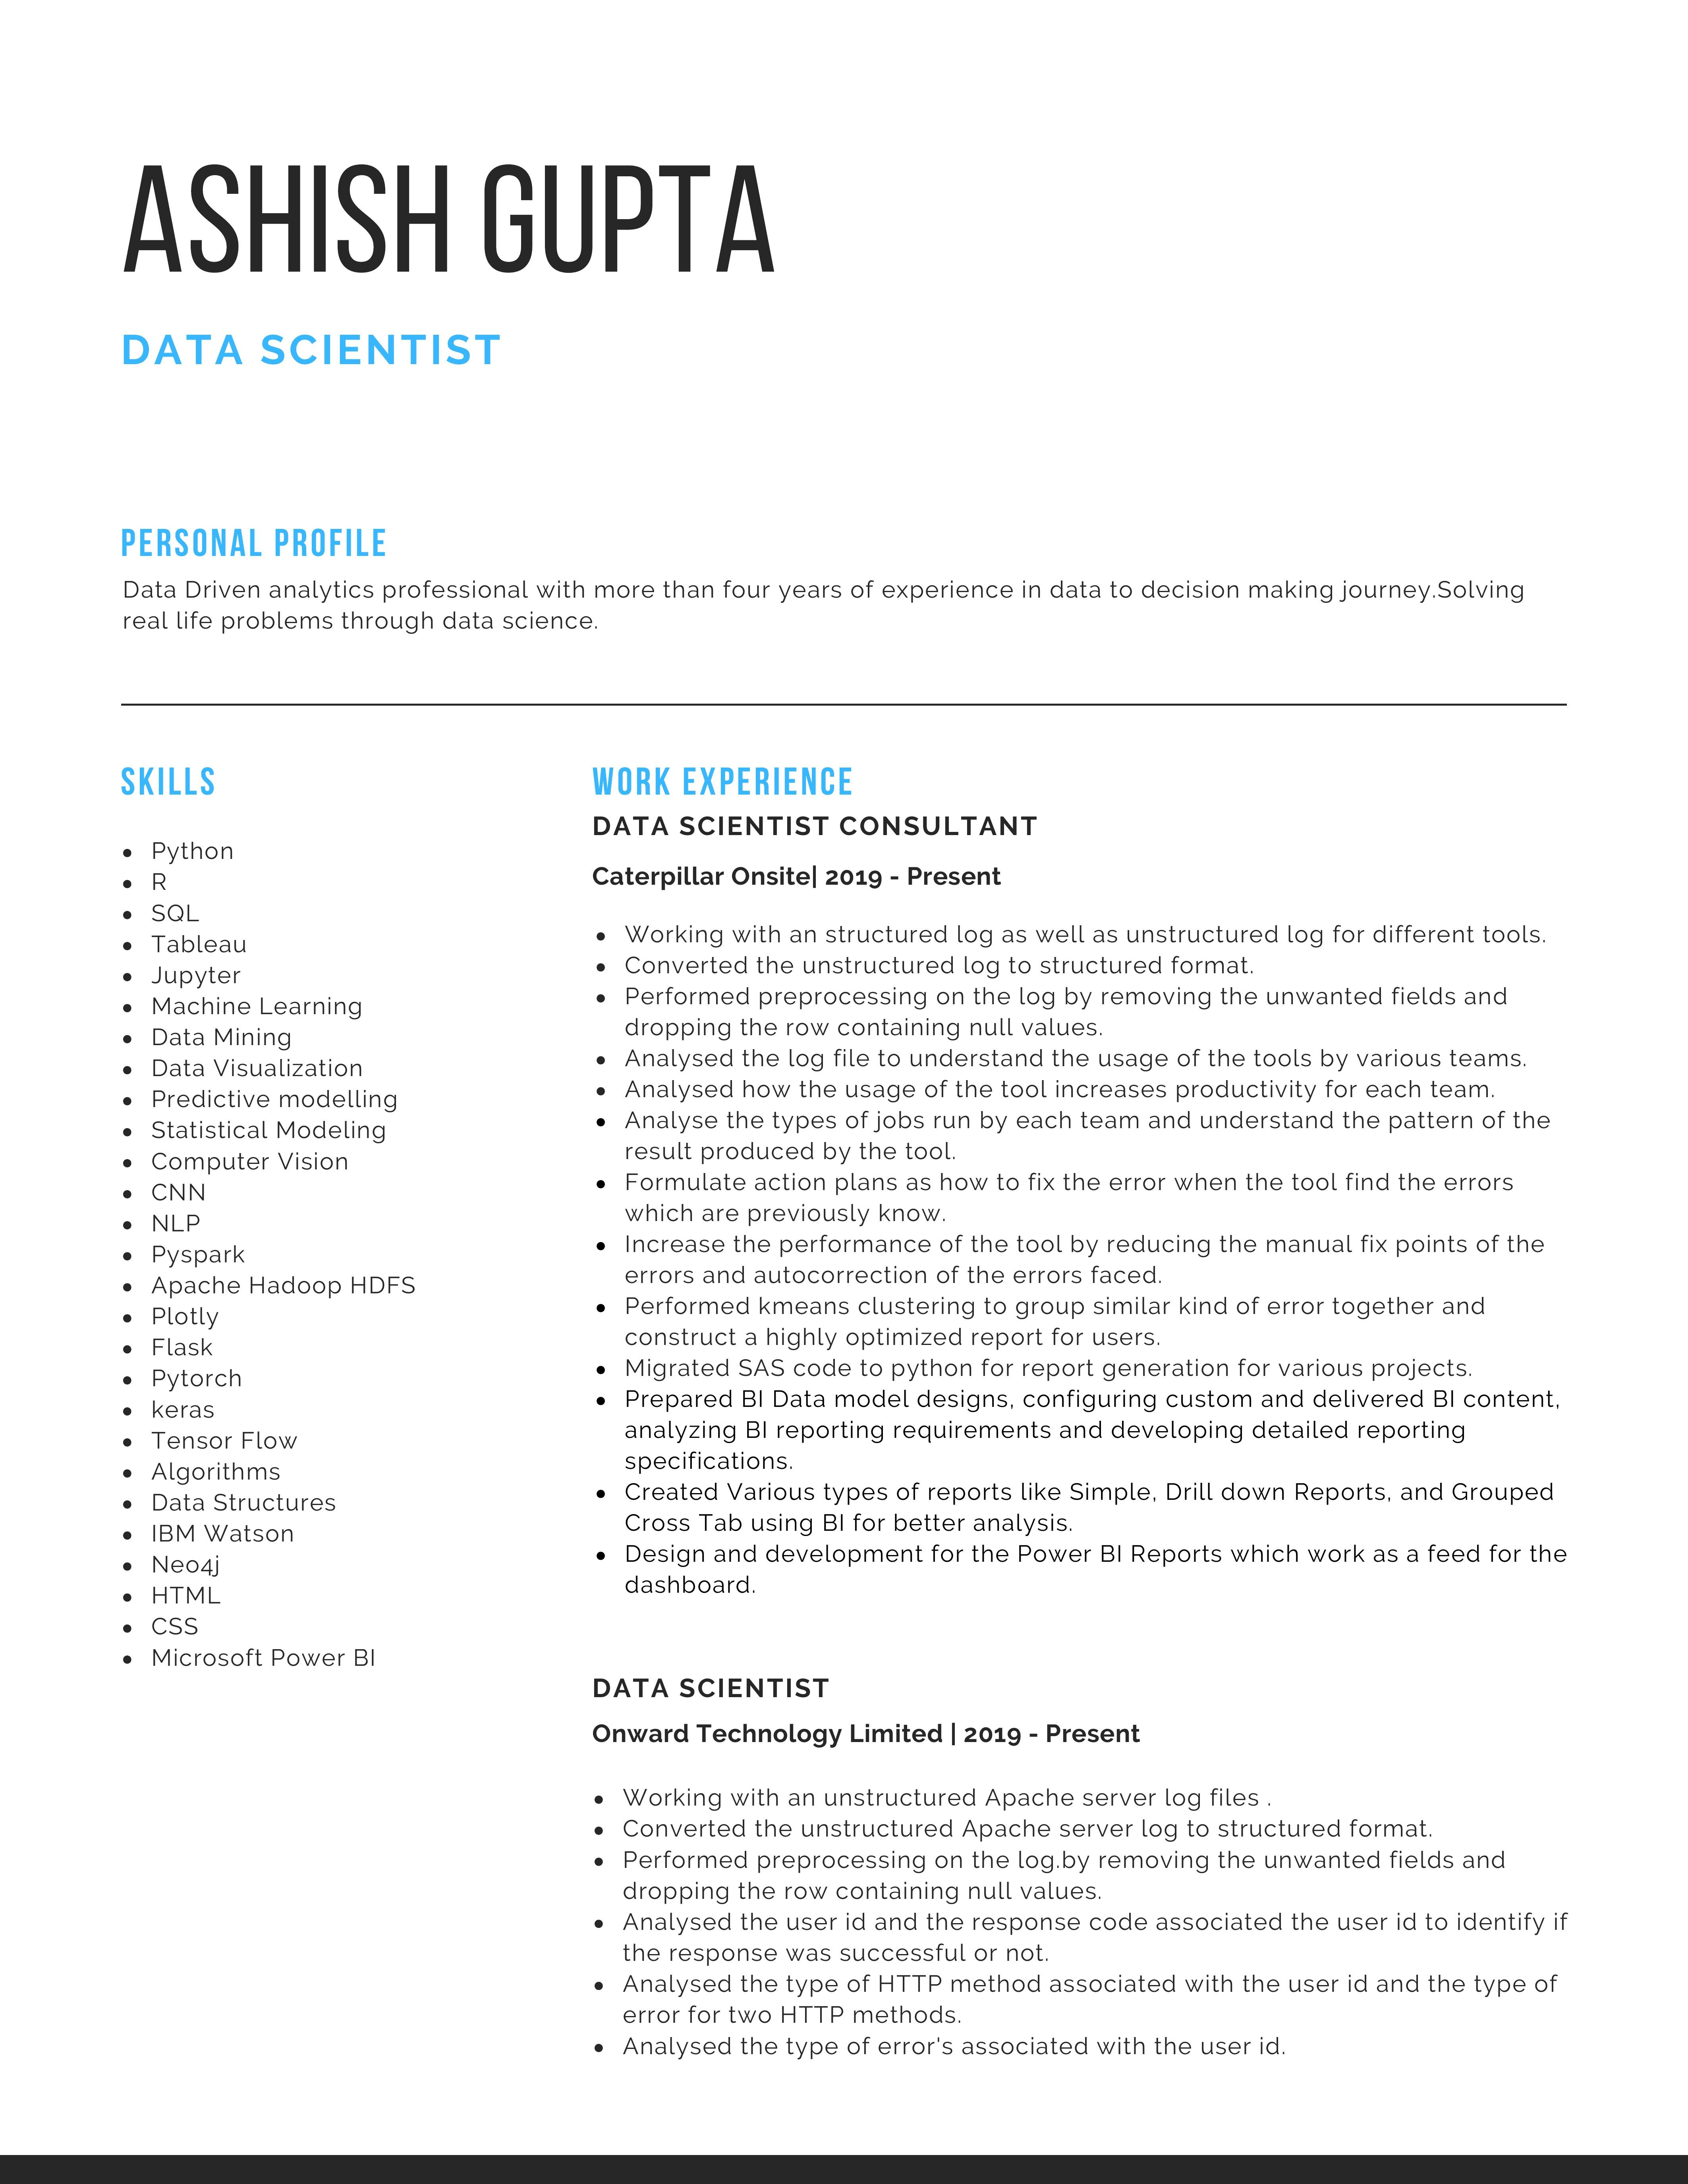

In [18]:
im  = cv2.imread(os.path.join('Data Scientist/temp',image))
cv2.imwrite('temp.jpg',im)
display.Image(filename='temp.jpg')

In [128]:
import pandas as pd

data = [line.split('\t') for line in frame1.splitlines()]
df = pd.DataFrame(data[1:])
df.columns = data[0]


data = [line.split('\t') for line in frame.splitlines()]
df1 = pd.DataFrame(data[1:])
df1 = df1[0].str.split(' ', expand=True)

In [129]:
# df1 =  df[df.columns[6:10]].astype(int)
# FilteredConts = FilterContours(df1.values[1:])


# df1 = df1.iloc[1:].drop_duplicates()
# df1['Serial'] = np.arange(len(df1)).astype(str)
# df1['Points1'] = list(zip(df1['left'], df1['top']+df1['height']))
# H_thr = df1['height'].quantile(0.8)
# df1['Cluster1'] = FindNearestClusterPoints(df1['Points1'].tolist(), H_thr*1.8)


In [104]:
# resize=False
# kernel_size = 1
# file = os.path.join('Data Scientist/temp',image)
# im = BoundingBox1(file,kernel_size=kernel_size,Filter=True, Save=True,contours=FilteredConts[:,:4],
#                  Remove_Lines=False,resize=resize, labels=df1['Serial'].astype(str).tolist())
# cv2.imwrite('BindingBox4.jpg',im)
# display.Image(filename='BindingBox4.jpg',width=800,height=400)


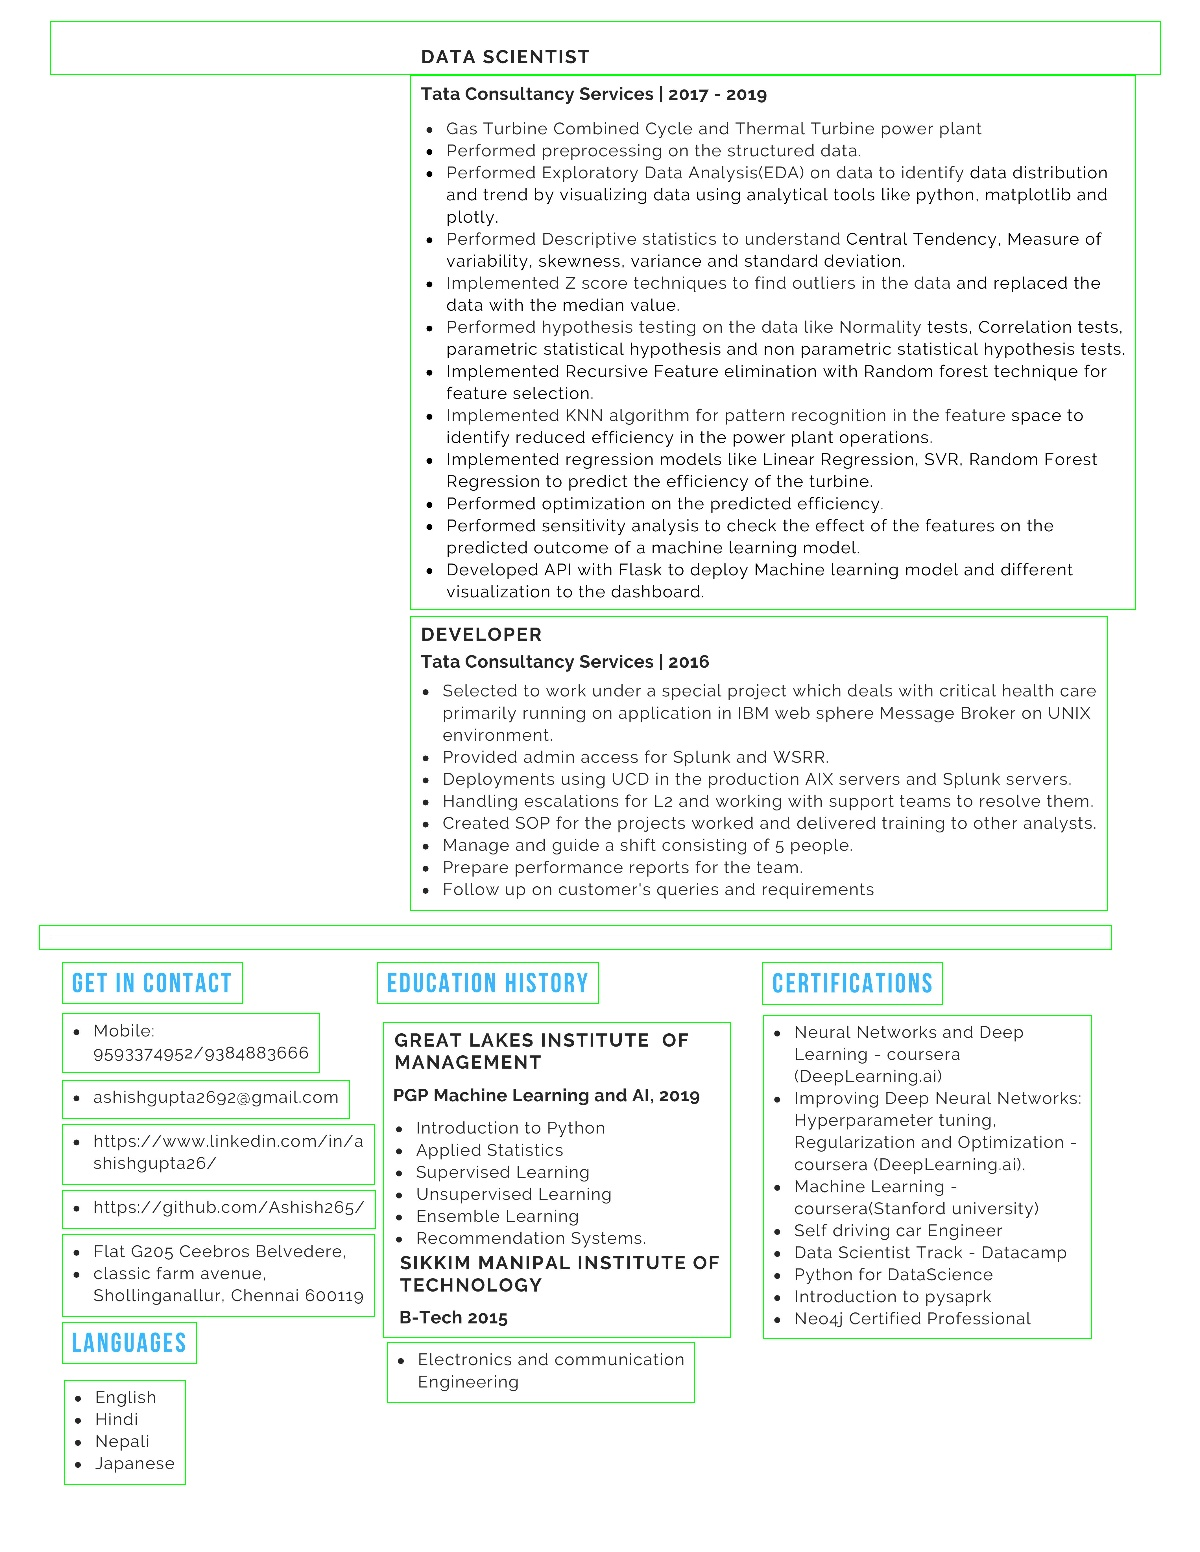

In [131]:
resize=True
kernel_size = 3

#file = os.path.join(path,'Data Scientist\\temp',image)
file = os.path.join('Data Scientist/temp',image)
# path = r'D:\Projects\TCS\OCR\SafetyCharacters\temp\image'
word_contours, word_cordinates, im, Original,hierarchy = BoundingBox1(file,kernel_size=kernel_size,Filter=True, Save=False, 
                                                                     Remove_Lines=True, resize=resize)
cv2.imwrite('BindingBox4.jpg',im)
display.Image(filename='BindingBox4.jpg',width=800,height=400)

In [132]:
FilteredConts = np.array(word_cordinates)*(Original.shape[1]/im.shape[1])
FilteredConts = FilteredConts.astype(int)

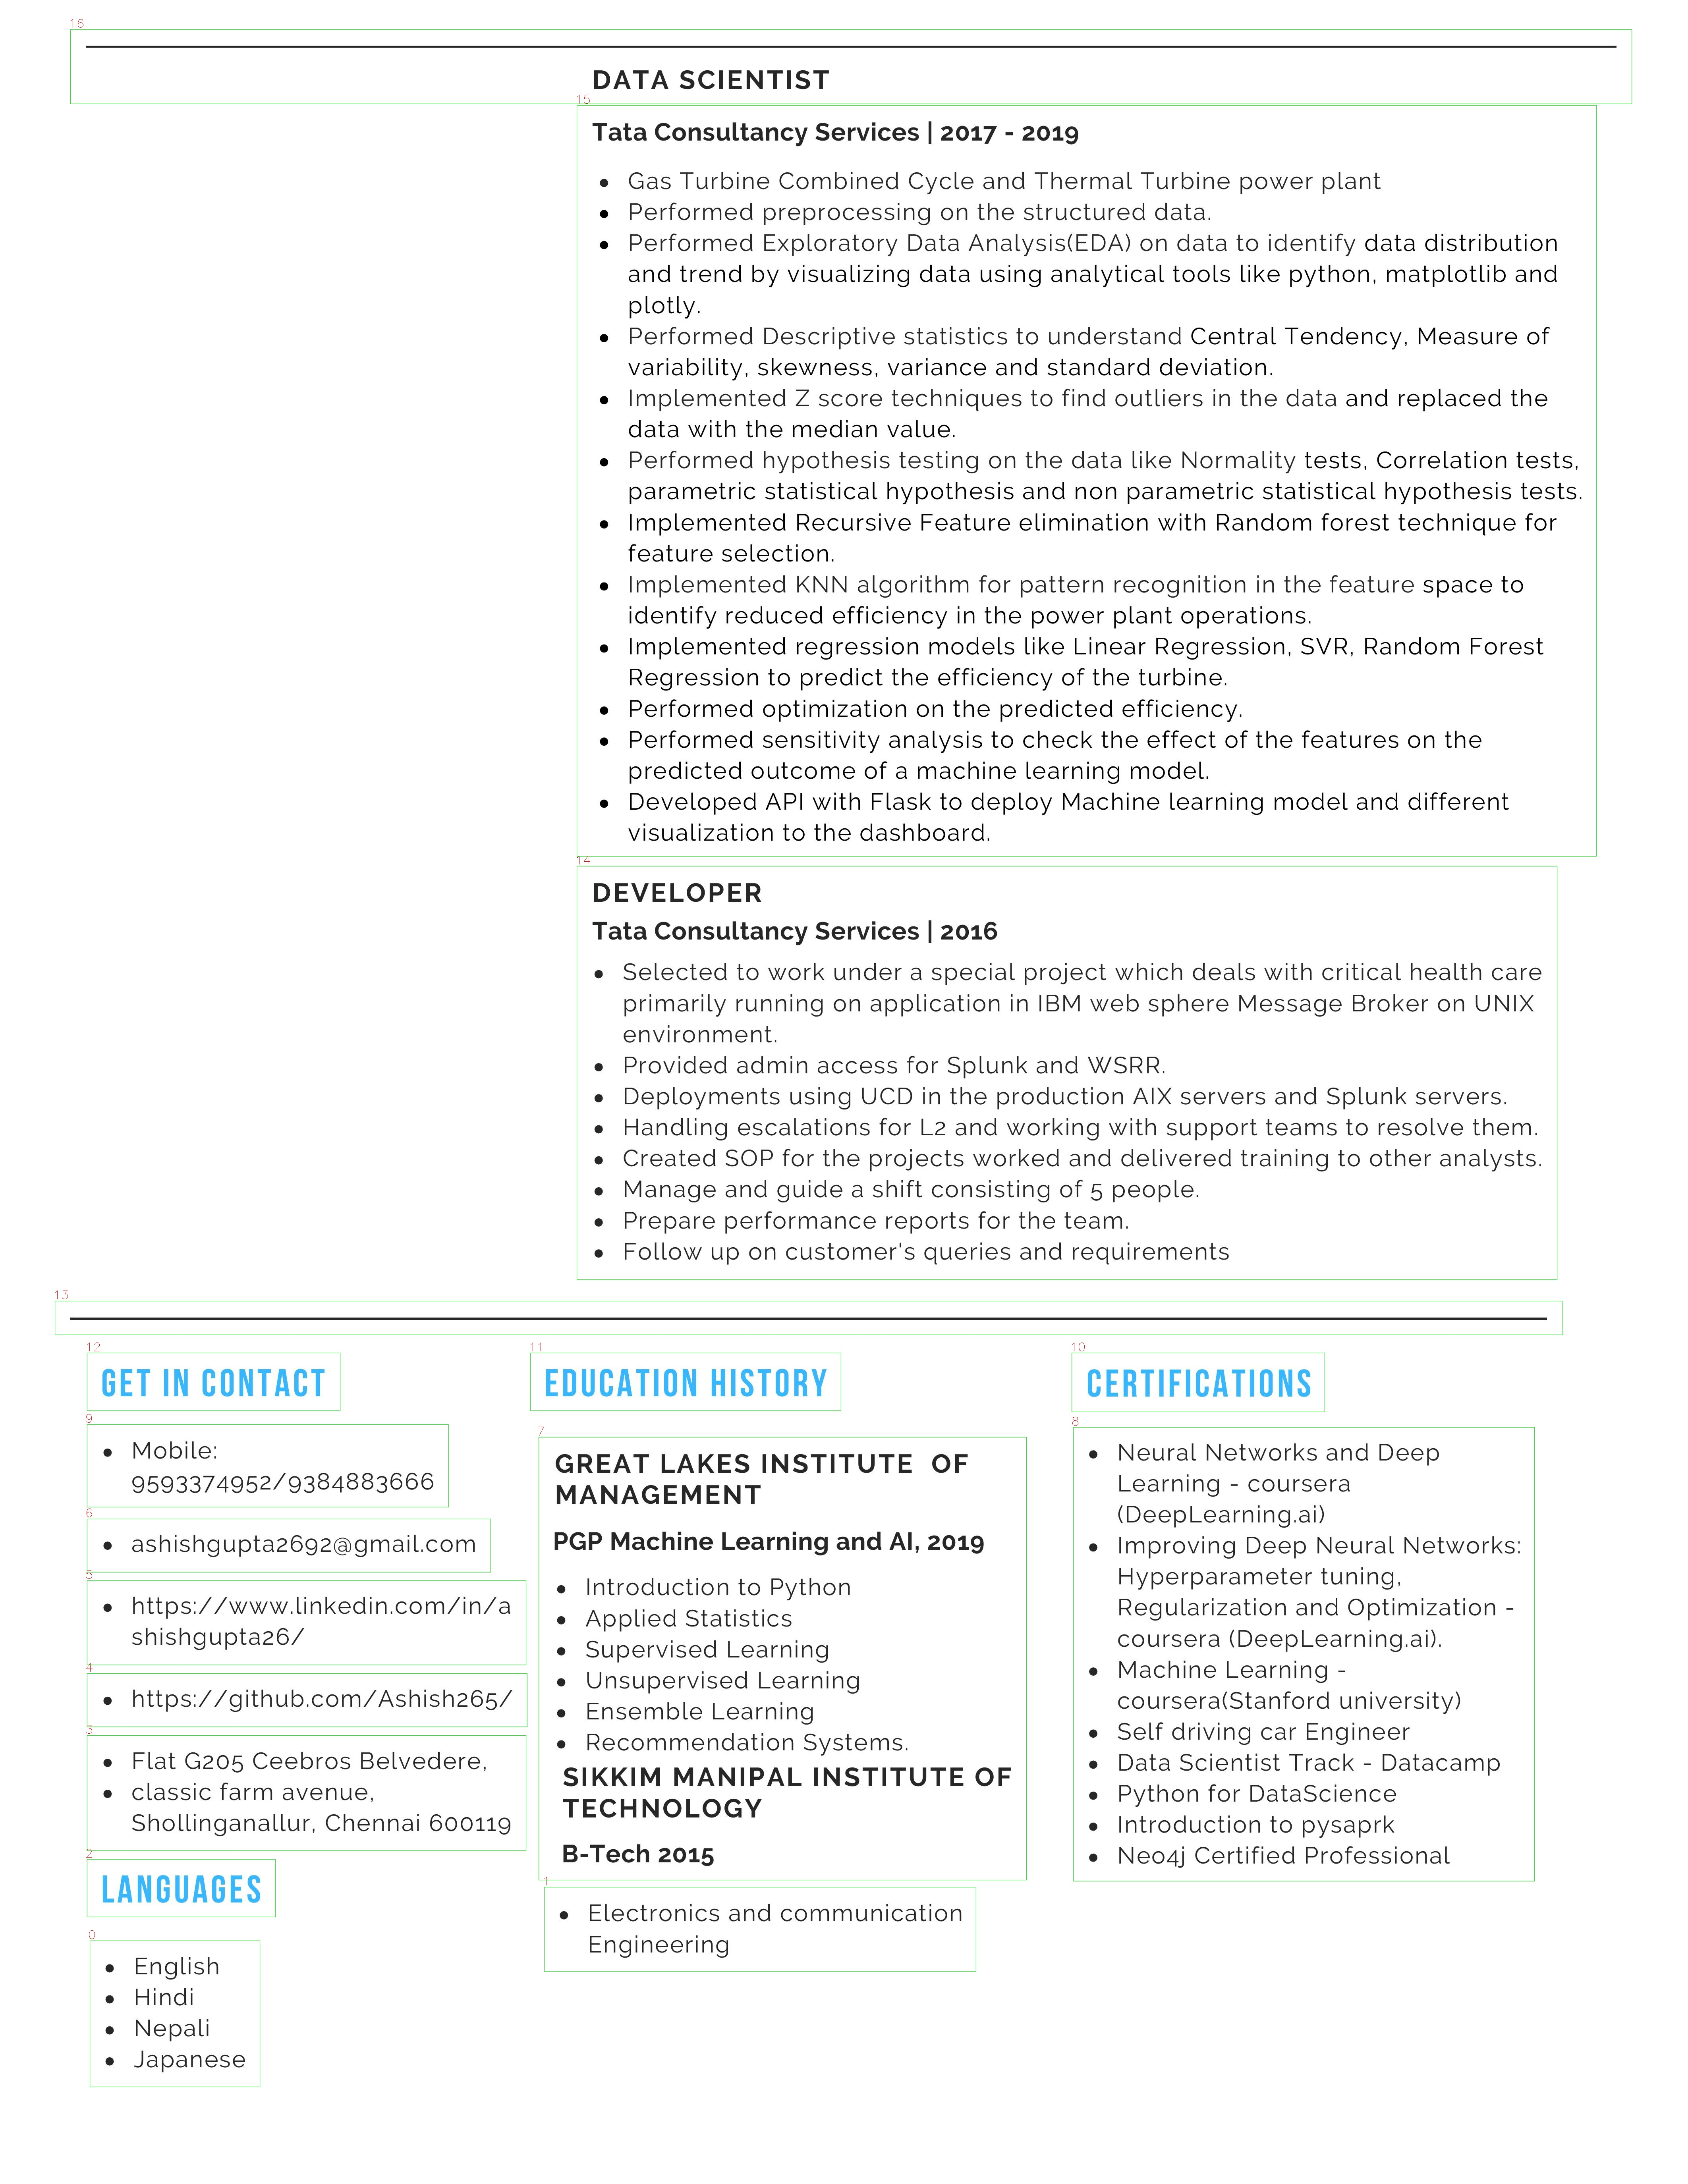

In [133]:
resize=False
kernel_size = 1
file = os.path.join('Data Scientist/temp',image)
im = BoundingBox1(file,kernel_size=kernel_size,Filter=True, Save=True,contours=FilteredConts[:,:4],
                 Remove_Lines=False,resize=resize, labels=list(np.arange(len(FilteredConts)).astype(str)))
cv2.imwrite('BindingBox4.jpg',im)
display.Image(filename='BindingBox4.jpg',width=800,height=400)


In [134]:
df2 = pd.DataFrame(FilteredConts)

In [162]:
t_list = []  
d_list = []
for co in FilteredConts:
    te = Original[co[1]:co[1]+co[3], co[0]:co[0]+co[2]]
    cv2.imwrite('temp.jpg',te)
    text = pytesseract.image_to_string('temp.jpg')
    try:
        frame = pytesseract.image_to_boxes('temp.jpg')
        data = [line.split('\t') for line in frame.splitlines()]
        df3 = pd.DataFrame(data[1:])
        df3 = df3[0].str.split(' ', expand=True)
        df3 = df3.set_index(0).astype(int).reset_index()
        #d_list.append(df3[4].subtract(df3[2]).describe())
        d_list.append(df3[4].subtract(df3[2]).describe()['75%'])
    except:
        d_list.append(0)
    t_list.append(text)

In [137]:
df.head()

level page_num block_num par_num line_num word_num left   top width height  \
0     1        1         0       0        0        0    0     0  4250   5500   
1     2        1         1       0        0        0  258  3447   559     70   
2     3        1         1       1        0        0  258  3447   559     70   
3     4        1         1       1        1        0  258  3447   559     70   
4     5        1         1       1        1        1  258  3447   120     70   

  conf text  
0   -1       
1   -1       
2   -1       
3   -1       
4   93  GET

In [164]:
df2['SizeQ'] = d_list

In [166]:
df2

0     1     2     3                                               text  \
0    226  4887   428   368                   English\nHindi\nNepali\nJapanese   
1   1370  4752  1087   212       e Electronics and communication\nEngineering   
2    219  4682   474   145                                          LANGUAGES   
3    219  4370  1105   290  e Flat G205 Ceebros Belvedere,\ne classic farm...   
4    219  4214  1108   134                    e https://github.com/Ashish265/   
5    219  3980  1105   212     e https://www.linkedin.com/in/a\nshishgupta26/   
6    219  3825  1016   134                       e ashishgupta2z692@gmail.com   
7   1356  3619  1228  1115  GREAT LAKES INSTITUTE OF\nMANAGEMENT\n\nPGP Ma...   
8   2702  3594  1161  1143  Neural Networks and Deep\nLearning - coursera\...   
9    219  3587   910   208                   e Mobile:\n9593374952/9384883666   
10  2698  3407   637   148                                     CERTIFICATIONS   
11  1335  3407   782   145                                  EDUCATION HISTORY   
12   219  3407   637   145                                     GET IN CONTACT   
13   138  3276  3796    85                                                      
14  1452  2181  2468  1041  DEVELOPER\nTata Consultancy Services | 2016\n\...   
15  1452   265  2567  1891  Tata Consultancy Services | 2017 - 2019\n\ne G...   
16   177    74  3931   187                                     DATA SCIENTIST   

    SizeQ  
0   44.00  
1   43.00  
2   70.00  
3   43.00  
4   43.00  
5   43.00  
6   43.00  
7   47.00  
8   43.00  
9   43.00  
10  70.00  
11  70.00  
12  70.00  
13   0.00  
14  44.00  
15  44.00  
16  47.25

In [93]:
print(text)

English
Hindi
Nepali
Japanese


In [2]:
import os
path = r'D:\Projects\Projects2\Others\CharObjects\VoTT\Labels\SChars-TFRecords-export'
files = os.listdir(path)

In [3]:
file = files[0].split('_')
file[1] = file[1].zfill(6)

In [4]:
for file in os.listdir(path):
    file1 = file.split('_')
    file1[1] = file1[1].zfill(6)
    file1 = '_'.join(file1)
    os.rename(os.path.join(path,file), os.path.join(path,file1))

In [17]:
import re
re.findall(r'\d+',"{'SAP notification number': 400556095}")

['400556095']